In [1]:
import torch
from torch import nn
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

/global/homes/d/danieltm/.conda/envs/gnn4na/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Transformer Version

In [2]:
def transformer_update(h, num_hidden, linear_q, linear_k, linear_v, softmax):

    # apply linear layers to compute query, key, and value
    q = linear_q(h)
    k = linear_k(h)
    v = linear_v(h)

    # compute dot product of query and key, and apply softmax
    dot_product = torch.matmul(q, k.transpose(2, 3)) / math.sqrt(num_hidden)
    attn_weights = softmax(dot_product)

    # apply dot product of attention weights and value
    attn_output = torch.matmul(attn_weights, v)
    
    return attn_output

In [3]:
def transformer_update_2(h, num_hidden, linear_q, linear_k, linear_v, softmax):

    # apply linear layers to compute query, key, and value
    q = linear_q(h)
    k = linear_k(h)
    v = linear_v(h)

    # compute dot product of query and key, and apply softmax
    dot_product = torch.matmul(k.transpose(2, 3), v)

    # apply dot product of attention weights and value
    attn_output = torch.matmul(v, dot_product)
    
    return attn_output

In [4]:
def run_transformer_update(num_nodes, num_hidden, batch_size = 1, attention_heads = 1, num_iters=1000):
    
    linear_q = nn.Linear(num_hidden, num_hidden).to("cuda")
    linear_k = nn.Linear(num_hidden, num_hidden).to("cuda")
    linear_v = nn.Linear(num_hidden, num_hidden).to("cuda")
    softmax = nn.Softmax(dim=-1).to("cuda")
    
    # Set pytorch random seed
    torch.manual_seed(0);
    h = torch.randn(batch_size, attention_heads, num_nodes, num_hidden).to("cuda")

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()

    for i in range(num_iters):
        transformer_update_2(h, num_hidden, linear_q, linear_k, linear_v, softmax)
        torch.cuda.synchronize()    

    end.record()
    torch.cuda.synchronize()

    return start.elapsed_time(end) / num_iters, torch.cuda.max_memory_allocated() / 1e6

In [5]:
num_nodes = 10
num_hidden = 10
batch_size = 1
attention_heads = 1

In [6]:
num_iters=10
timing, memory = run_transformer_update(int(num_nodes), int(num_hidden), batch_size, attention_heads, num_iters)
print(timing, "ms", memory, "MB")

49.335296630859375 ms 0.006144 MB


In [7]:
torch.cuda.reset_max_memory_allocated()

/global/homes/d/danieltm/.conda/envs/gnn4na/lib/python3.9/site-packages/torch/cuda/memory.py:278: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [8]:
batch_size = 1
attention_heads = 1
num_iters=10
nums_nodes = []
nums_hidden = []
timings = []
memorys = []

for num_nodes in tqdm(np.logspace(1, 5, num=13, base=10)):
    for num_hidden in np.logspace(1, 4, num=10, base=10):
        # print("-------\n", "N:", int(num_nodes), "H:", int(num_hidden))
        nums_hidden.append(num_hidden)
        nums_nodes.append(num_nodes)
        try:
            timing, memory = run_transformer_update(int(num_nodes), int(num_hidden), batch_size, attention_heads, num_iters)
            timings.append(timing)
            memorys.append(memory)
            # print(timing, "ms", memory, "MB")
        except:
            # print("OOM!")
            timings.append(np.nan)
            memorys.append(np.nan)

        torch.cuda.reset_max_memory_allocated()     

100%|██████████| 13/13 [03:07<00:00, 14.46s/it]


In [9]:
perf_df = pd.DataFrame({"num_nodes": nums_nodes, "num_hidden": nums_hidden, "timing": timings, "memory": memorys})

In [10]:
perf_df.to_csv("transformer_1_perf.csv")

In [10]:
perf_df.to_csv("transformer_2_perf.csv")

## GNN Version

In [2]:
from torch_scatter import scatter_add
from torch_geometric import utils
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set pytorch random seed
torch.manual_seed(0);

In [4]:
def gnn_update(h, edges, linear_q, linear_k, linear_v):
    
    q = linear_q(h)
    k = linear_k(h)
    v = linear_v(h)

    incoming, outgoing = edges
    dot_product = (q[incoming]*k[outgoing]).sum(dim=-1) / math.sqrt(num_hidden)
    attn_weights = utils.softmax(dot_product, incoming, dim=0)

    attn_output = scatter_add(attn_weights[:, None]*v[outgoing], incoming, dim=0, dim_size=h.shape[0])

    return attn_output    

In [5]:
def run_gnn_update(num_nodes, num_hidden, batch_size = 1, attention_heads = 1, num_iters=1000):
    
    linear_q = nn.Linear(num_hidden, num_hidden).to("cuda")
    linear_k = nn.Linear(num_hidden, num_hidden).to("cuda")
    linear_v = nn.Linear(num_hidden, num_hidden).to("cuda")
    softmax = nn.Softmax(dim=-1).to("cuda")
    
    # Set pytorch random seed
    torch.manual_seed(0);
    h = torch.randn(num_nodes, num_hidden).to("cuda")
    edges = torch.stack(torch.meshgrid(torch.arange(num_nodes), torch.arange(num_nodes))).reshape(2, -1).to("cuda")

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()

    for i in range(num_iters):
        gnn_update(h, edges, linear_q, linear_k, linear_v)
        torch.cuda.synchronize()    

    end.record()
    torch.cuda.synchronize()

    return start.elapsed_time(end) / num_iters, torch.cuda.max_memory_allocated() / 1e6

In [6]:
num_nodes = 10
num_hidden = 10
batch_size = 1
attention_heads = 1

In [7]:
num_iters=10
timing, memory = run_gnn_update(int(num_nodes), int(num_hidden), batch_size, attention_heads, num_iters)
print(timing, "ms", memory, "MB")

52.683056640625 ms 1.055744 MB


In [8]:
torch.cuda.reset_max_memory_allocated()

In [9]:
batch_size = 1
attention_heads = 1
num_iters=10
nums_nodes = []
nums_hidden = []
timings = []
memorys = []

for num_nodes in tqdm(np.logspace(1, 4, num=10, base=10)):
    for num_hidden in np.logspace(1, 4, num=10, base=10):
        # print("-------\n", "N:", int(num_nodes), "H:", int(num_hidden))
        nums_hidden.append(num_hidden)
        nums_nodes.append(num_nodes)
        try:
            timing, memory = run_gnn_update(int(num_nodes), int(num_hidden), batch_size, attention_heads, num_iters)
            timings.append(timing)
            memorys.append(memory)
            # print(timing, "ms", memory, "MB")
        except:
            # print("OOM!")
            timings.append(np.nan)
            memorys.append(np.nan)

        torch.cuda.reset_max_memory_allocated()     

100%|██████████| 10/10 [01:01<00:00,  6.14s/it]


In [10]:
perf_df = pd.DataFrame({"num_nodes": nums_nodes, "num_hidden": nums_hidden, "timing": timings, "memory": memorys})

In [11]:
perf_df.to_csv("gnn_1_perf.csv")

## Compare Transformer and GNN

In [2]:
tran1_df = pd.read_csv("transformer_1_perf.csv")
tran2_df = pd.read_csv("transformer_2_perf.csv")
gnn_df = pd.read_csv("gnn_1_perf.csv")

In [7]:
tran1_df.num_nodes.unique(), tran2_df.num_nodes.unique(), gnn_df.num_nodes.unique()

(array([   10.        ,    21.5443469 ,    46.41588834,   100.        ,
          215.443469  ,   464.15888336,  1000.        ,  2154.43469003,
         4641.58883361, 10000.        ]),
 array([1.00000000e+01, 2.15443469e+01, 4.64158883e+01, 1.00000000e+02,
        2.15443469e+02, 4.64158883e+02, 1.00000000e+03, 2.15443469e+03,
        4.64158883e+03, 1.00000000e+04, 2.15443469e+04, 4.64158883e+04,
        1.00000000e+05]),
 array([   10.        ,    21.5443469 ,    46.41588834,   100.        ,
          215.443469  ,   464.15888336,  1000.        ,  2154.43469003,
         4641.58883361, 10000.        ]))

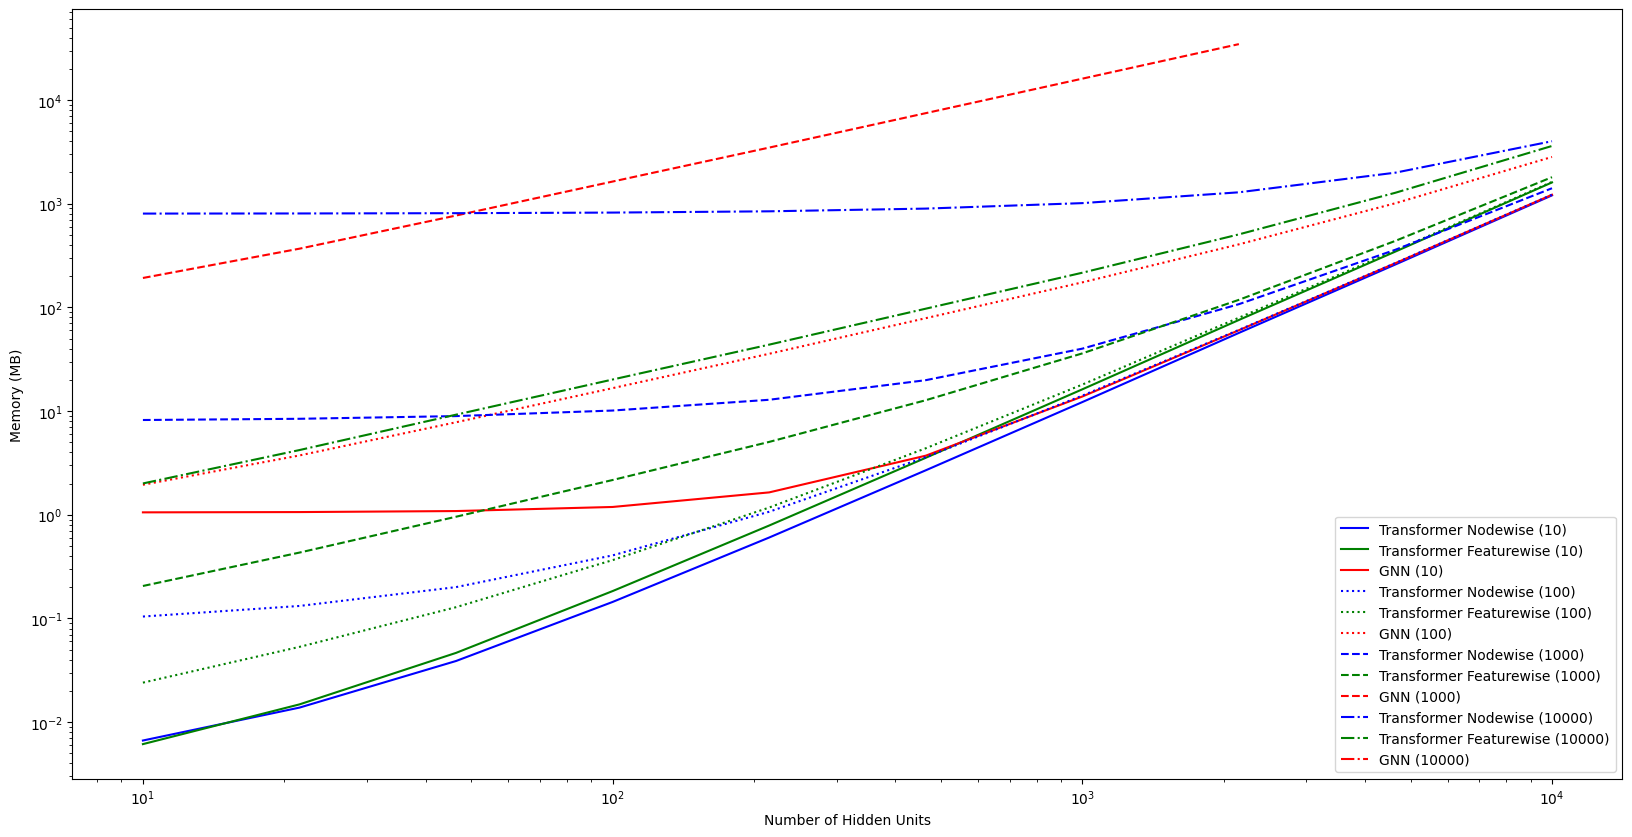

In [12]:
plt.figure(figsize=(20, 10))

# for num_nodes in [10, 100, 1000, 10000]:
#     plt.plot(tran1_df[tran1_df.num_nodes == num_nodes].num_hidden, tran1_df[tran1_df.num_nodes == num_nodes].memory, c="b", label="Transformer Nodewise")
#     plt.plot(tran2_df[tran2_df.num_nodes == num_nodes].num_hidden, tran2_df[tran2_df.num_nodes == num_nodes].memory, c="g", label="Transformer Featurewise")
#     plt.plot(gnn_df[gnn_df.num_nodes == num_nodes].num_hidden, gnn_df[gnn_df.num_nodes == num_nodes].memory, c="r", label="GNN")

# do the above, but with different dotted lines for each line
for num_nodes in zip([10, 100, 1000, 10000], ["solid", "dotted", "dashed", "dashdot"]):
    plt.plot(tran1_df[tran1_df.num_nodes == num_nodes[0]].num_hidden, tran1_df[tran1_df.num_nodes == num_nodes[0]].memory, c="b", label=f"Transformer Nodewise ({num_nodes[0]})", linestyle=num_nodes[1])
    plt.plot(tran2_df[tran2_df.num_nodes == num_nodes[0]].num_hidden, tran2_df[tran2_df.num_nodes == num_nodes[0]].memory, c="g", label=f"Transformer Featurewise ({num_nodes[0]})", linestyle=num_nodes[1])
    plt.plot(gnn_df[gnn_df.num_nodes == num_nodes[0]].num_hidden, gnn_df[gnn_df.num_nodes == num_nodes[0]].memory, c="r", label=f"GNN ({num_nodes[0]})", linestyle=num_nodes[1])
plt.yscale("log")
plt.xscale("log")

plt.xlabel("Number of Hidden Units")
plt.ylabel("Memory (MB)")
plt.legend()

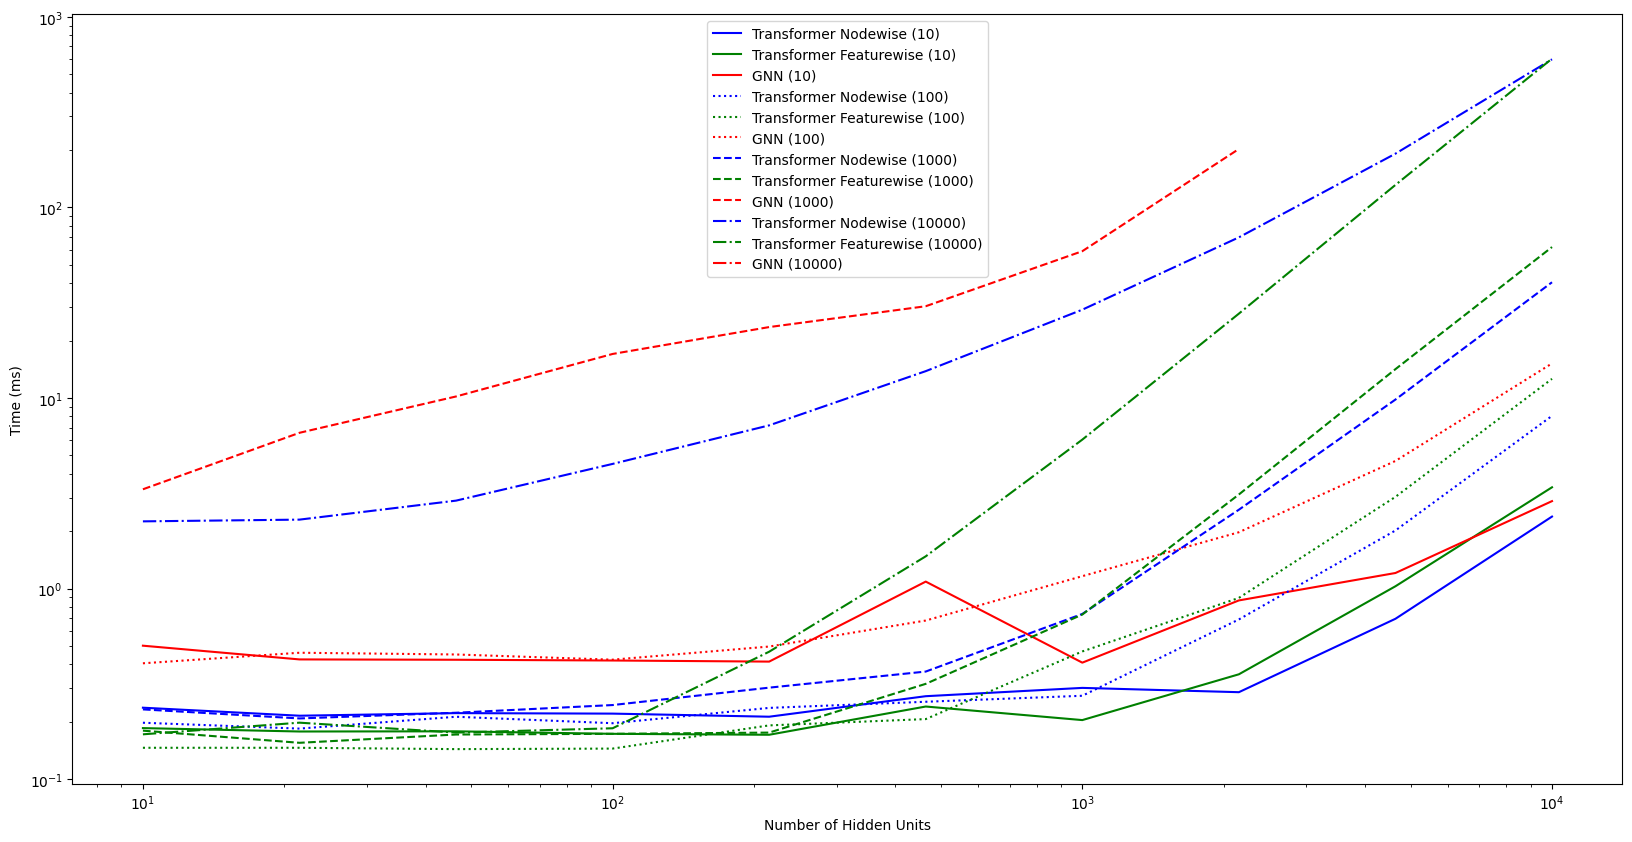

In [14]:
# for num_nodes in [10, 100, 1000, 10000]:
#     plt.plot(tran1_df[tran1_df.num_nodes == num_nodes].num_hidden, tran1_df[tran1_df.num_nodes == num_nodes].timing, c="b")
#     plt.plot(tran2_df[tran2_df.num_nodes == num_nodes].num_hidden, tran2_df[tran2_df.num_nodes == num_nodes].timing, c="g")
#     plt.plot(gnn_df[gnn_df.num_nodes == num_nodes].num_hidden, gnn_df[gnn_df.num_nodes == num_nodes].timing, c="r")

plt.figure(figsize=(20, 10))
for num_nodes in zip([10, 100, 1000, 10000], ["solid", "dotted", "dashed", "dashdot"]):
    plt.plot(tran1_df[tran1_df.num_nodes == num_nodes[0]].num_hidden, tran1_df[tran1_df.num_nodes == num_nodes[0]].timing, c="b", label=f"Transformer Nodewise ({num_nodes[0]})", linestyle=num_nodes[1])
    plt.plot(tran2_df[tran2_df.num_nodes == num_nodes[0]].num_hidden, tran2_df[tran2_df.num_nodes == num_nodes[0]].timing, c="g", label=f"Transformer Featurewise ({num_nodes[0]})", linestyle=num_nodes[1])
    plt.plot(gnn_df[gnn_df.num_nodes == num_nodes[0]].num_hidden, gnn_df[gnn_df.num_nodes == num_nodes[0]].timing, c="r", label=f"GNN ({num_nodes[0]})", linestyle=num_nodes[1])

plt.yscale("log")
plt.xscale("log")

plt.xlabel("Number of Hidden Units")
plt.ylabel("Time (ms)")
plt.legend()